# EM

We present a brief explanation of the EM algorithm, for a more extensive and detailed explanation see the file **theory/em**.


The Expectation-maximization (EM) algorithm is an iterative method for finding maximum-likelihood estimates of parameters in statistical models, where the models depend on un-observed latent or hidden variables $z$. Latent variables are variables that are not directly observed but are rather inferred from other variables $x$ that are observed. The likelihood $p(x)$ of a hidden model then becomes $\sum_z p(x,z)$

## Setup

To learn the parameters of a model [maximum likelihood estimation](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation) can be used, It maximize the log-likelihood of the dataset. We derive the log-likelihood for a model with latent variables
$$
\begin{aligned}
    \log p(x_{1:n}| \theta) &= \log \prod_{i=1}^n p(x_i| \theta)\\
    &= \sum_{i=1}^n \log p(x_i| \theta)\\
    &= \sum_{i=1}^n \log \sum_{z_i} p(x_i, z_i| \theta)\\
\end{aligned}$$
This gives a multi-modal optimization problem that is non convex (hard!) because of the sum inside the $\log$ function. There are two main options in Machine Learning to learn the parameters of a latent-variable model.
1. Do gradient ascent on non-concave objective
2. EM algorithm. Its a block-coordinate ascent on an **auxiliary function** with lower bound $\log p(x_{1:n}| \theta)$. It has a nice interpretation in terms of filling "missing data" : the E step fills z with "soft-values" and the M step maximize with respect to $\theta$ for the "fully observed" model.

The auxiliary function we will optimize is

## ELBO

### Jensen's inequality

We will use the following properties :
1. if $f:\mathbb{R} \rightarrow \mathbb{R}$ is convex and if $X$ is an integrable random variable  :
  $$\mathbb{E}_X(f(X))\geq f(\mathbb{E}_X(X))$$
  The opposite is true for a concave function.
2. if $f:\mathbb{R} \rightarrow \mathbb{R}$ is strictly convex, we have equality in the previous inequality if and only if 
 $X$ = constant a.s.

### Derivation

We derive the auxiliary function that the EM algorithm will optimize instead of the log-likelihood in the discrete case. In the continuous case, replace sums by integrals. 

\begin{align*}
    \log p(x|\theta) &=\log \sum_z p(x,z|\theta) \\
    &= \log \sum_z q(z) \frac{p(x,z|\theta)}{q(z)} \quad\quad \text{($q(z)\ne0$ is any function on $z$)}\\
    &= \log\left(\mathbb{E}_q \left[\frac{p(x,z|\theta)}{q(z)}\right] \right) \\ 
    &\ge \mathbb{E}_q \left[ \log \left(\frac{p(x,z|\theta)}{q(z)} \right) \right]  \quad\quad \text{(Jensen's inequality : $\log$ is  concave)}\\
    &= \sum_z q(z) \log \left(\frac{p(x,z|\theta)}{q(z)} \right) \\
    &= \sum_z q(z) \log p(x,z|\theta) - \sum_z q(z) \log q(z)
\end{align*}

The last line is called the **E**vidence **L**ower **BO**und ([ELBO](https://en.wikipedia.org/wiki/Evidence_lower_bound)) and it is the auxiliary function we were looking for and it described in the following equation

\begin{equation}
    \boxed{\mathcal{L}(q,\theta) = \mathbb{E}_q[\log p(x,z|\theta)] + H(q)}
\end{equation}


Where $p(x,z|\theta)$ is the **complete likelihood**,  $\mathbb{E}_q[\log p(x,z|\theta)]$ the **expected complete log-likelihood** and $H(q)$ is the **entropy** of $q$. 


The ELBO is a lower bound on the log-likelihood : $\log p(x|\theta) \ge \mathcal{L}(q,\theta) \, \forall (q,\theta)$. This means, that maximizing the ELBO will improve the log-likelihood, which is the objective of maximum likelihood estimation, but it doesn't guarantee an optimal solution.

## Algorithm

Formally the algorithm is to repeate the next two steps until convergence:
1. **E step** : $q_{t+1} = arg\max_q \,  \mathcal{L}(q,\theta^{(t)})$
2. **M step** : $\theta^{(t+1)} = arg\max_\theta \, \mathcal{L}(q_{t+1},\theta^{(t)})$

It is a block-coordinate ascent on $\mathcal{L}(q,\theta)$, The E step is an ascent on the hidden variables and the M step an ascent on the visible variables. 

Looking at the E step, using Jensen's inequality property, we know that the inequality becomes an equality if $\frac{p(x,z)}{q(z)}$ is constant with respect to $z$. It means that
$$q(z) = \frac{p(x,z)}{\sum_z p(x,z)} = p(z|x,\theta)$$

Then we can conclude that 

$$arg\max_q \mathcal{L}(q,\theta)= p(z|x,\theta)$$

This is equivalent to computing $\mathbb{E}_q[z]$

Looking at the M step, $H(q)$ is constant with respect to $\theta$ so it can be removed. This steps needs **complete information**. To get it we replace $z$ with the $\mathbb{E}_q[z]$ computed in the E step. Then the process becomes the same as maximum likelihood estimation.


We prove that each pass of the algorith produce a $\theta_{t+1}$ that is better then the one before.

$$ \mathcal{L}(q_{t+1}, \theta^{(t)})=\log p(x|\theta^{(t)}) \le \mathcal{L}(q_{t+1}, \theta^{(t+1)}) \le \mathcal{L}(q_{t+2}, \theta^{(t+1)})=\log p(x|\theta^{(t+1)}) $$

Then
$$\log p(x|\theta^{(t)}) \le \log p(x|\theta^{(t+1)})$$


Then we can rewrite the EM algorithm.
1. **E step** : $q_{t+1}(z) = \mathbb{E}_{q_{t+1}}[z] = p(z|x,\theta_t)$
2. **M step** : $\theta^{(t+1)} = arg\max_\theta \mathbb{E}_{q_{t+1}}[\log p(x,z,\theta^{(t)})]$

# Application : Gaussian Mixture Model

## Setup

The sampling process for each new sample is assumed to be made in two steps. The first one consist in choosing randomly one of the $k$ available classes indepedently of the other samples that already exist, this is noted $Z_i \overset{iid}{\sim} Multinomial(\pi)$. The second step consit in creating the new sample by sampling the gaussian distribution of the chosen class, this is noted $X_i|Z_i = j \sim \mathcal{N}(\mu_j,\Sigma_j)$. All the parameters can be expressed in one vector in this way $\theta = (\pi, \{\mu_j\}_{j=1}^k, \{\Sigma_j\}_{j=1}^k)$. The corresponding graphical model is given by the following image
![title](pictures/gmm_pgm.png)

**complete likelihood** 
$$
\begin{aligned}
    p(x_{1:n},z_{1:n} | \theta^{(t)}) &= \prod_{i=1}^n p(x_i,z_i | \theta^{(t)}) \\
    &= \prod_{i=1}^n \prod_{j=1}^k p(x_i|z_{ij}, \theta^{(t)})^{z_{ij}} p(z_{ij} | \theta^{(t)})^{z_{ij}} \\
    &= \prod_{i=1}^n \prod_{j=1}^k \mathcal{N}(x_i|\mu_j^{(t)}, \Sigma_j^{(t)})^{z_{ij}}\pi_j^{z_{ij}} 
\end{aligned}$$

**complete log-likelihood** 
$$ \log p(x_{1:n},z_{1:n} | \theta^{(t)}) = \sum_{i=1}^n \sum_{j=1}^k z_{ij} [\log \mathcal{N} (x_i|\mu_j^{(t)},\Sigma_i^{(t)}) + \log(\pi_j^{(t)})]$$

## Derivation

### Expectation step

The unknown hidden variables are $z_{ij}$, for the M step we define weights to replace them

$$ \tau _{ij}^t = \mathbb{E}_{q}[Z_{ij}] = p(z_{ij}=1|x_i,\theta^{(t)})$$


We can then use [Baye's Rule](https://en.wikipedia.org/wiki/Bayes%27_theorem) to compute them using quantities we have acces to.

$$\tau _{ij}^t = \frac{p(x_i|z_{ij},\theta^{(t)})p(z_{ij}|\theta^{(t)})}{\sum_{j=1}^k p(x_i|z_{ij},\theta^{(t)}) p(z_{ij}|\theta^{(t)})}$$

We can then replace the different quantities by the coresponding ones in our problem to produce a formula for $\tau _{ij}^t$ !
$$\boxed{\tau _{ij}^t =\frac{\mathcal{N}(x_i|\mu_j^{(t)},\Sigma_j^{(t)}) \pi_j^{(t)}}{\sum_{j=1}^k \mathcal{N}(x_i|\mu_j^{(t)}, \Sigma_j^{(t)}) \pi_j^{(t)}}}$$

### Maximization Step

For $\pi^{t+1}$, we use the [Lagrangian method](https://en.wikipedia.org/wiki/Lagrangian_relaxation) because of the constraint $\sum_j \pi_j = 1$.
$$J(\pi, \lambda) = \sum_{i=1}^n \sum_{j=1}^k \tau _{ij}^t  [\log \mathcal{N}(x_i|\mu_j,\Sigma_i) + \log \pi_j]  + \lambda (1 - \sum_{j=1}^k \pi_j)$$

$$ \frac{\partial}{\partial \pi_j} J(\pi, \lambda) = \sum_{i=1}^n \frac{\tau _{ij}^t}{\pi_j} - \lambda = 0 \Rightarrow \pi_j = \frac{1}{\lambda} \sum_{i=1}^n \tau_{ij}^t$$


To find the value of $\lambda$, I use $\sum_{j=1}^k \tau_{ij}^t = 1$
$$ \sum_{j=1}^k \pi_j = \sum_{j=1}^k \frac{1}{\lambda} \sum_{i=1}^n \tau_{ij}^t 
    = \frac{1}{\lambda} \sum_{i=1}^n \sum_{j=1}^k \tau_{ij}^t 
    = \frac{1}{\lambda} \sum_{i=1}^n 1 
    = \frac{n}{\lambda}
    = 1 
\Rightarrow  \lambda = n$$
This means that
$$ \boxed{\pi_j^{(t+1)} = \frac{1}{n} \sum_{i=1}^n \tau_{ij}^t} $$

For the parameters of the gaussian we consider two cases : Isotropic, where the covariance matrix of each gaussian is assumed to be of the form $\Sigma_j = \sigma_j^2 I$, and Full, where the covariance matrix of each gaussian are fully parametrizable.

The log-likelihood for a gaussian distribution is the following:
$$\log \mathcal{N}(x_i|\mu_j,\Sigma_i)  = -\frac{d}{2}\log 2\pi - \frac{1}{2}\log |\Sigma| - \frac{1}{2}(x_i-\mu_j)^{\intercal}\Sigma_j^{-1}(x_i-\mu_j)$$

#### Isotropic Case

The constraint for the Isotropic case is that $\Sigma_j = \sigma_j^2 I$ which means that we can refromulate the log-likelihood of a single gaussian in the following way:

$$\log \mathcal{N}(x_i|\mu_j,\Sigma_i) = -\frac{d}{2}\log 2\pi - \frac{d}{2}\log \sigma_j^2 -\frac{(x_i-\mu_j)^{\intercal}(x_i-\mu_j)}{2\sigma_j^2}$$

Then using the weights $\tau _{ij}^t$ computed at the E step we can compute derive the update formula for the gaussians parameters.

For $\mu_j^{(t+1)}$. 
$$\frac{\partial}{\partial \mu_j} \mathbb{E}_{q}[\log p(x,z | \theta)] = -2 \sum_{i=1}^n \tau_{ij}^t \frac{(x_i-\mu_j)}{\sigma_j^2} =0 \Rightarrow \boxed{\mu_j^{(t+1)} = \frac{\sum_{i=1}^n \tau_{ij}^t x_i}{\sum_{i=1}^n \tau _{ij}^t}} $$
    
For ${\sigma_j^2}^{(t+1)}$. 
$$\frac{\partial}{\partial \sigma_j^2} \mathbb{E}_{q}[\log p(x,z | \theta)] = \sum_{i=1}^n \tau _{ij}^t \left[\frac{-1}{\sigma_j^2} + \frac{(x-\mu)^{\intercal}(x-\mu)}{(\sigma_j^2)^2} \right] = 0 \Rightarrow \boxed{{\sigma_j^2}^{(t+1)} = \frac{\sum_{i=1}^n \tau_{ij}^t (x-\mu)^{\intercal}(x-\mu)}{\sum_{i=1}^n \tau_{ij}^t}}$$

#### Full Case

There is no constraint in this case but we still reformulate the log-likelihood of a single gaussian to make the derivation easier to do. To accomplish this ee use two properties of traces :
1. $(x-\mu)^{\intercal}\Sigma^{-1}(x-\mu) = Tr((x-\mu)^{\intercal}\Sigma^{-1}(x-\mu))$ because $(x-\mu)^{\intercal}\Sigma^{-1}(x-\mu)$ is a scalar
2. $Tr(AB)=Tr(BA)$

$$\log \mathcal{N}(x_i|\mu_j,\Sigma_i)  = -\frac{d}{2}\log 2\pi + \frac{1}{2}\log |\Sigma_j^{-1}| - \frac{1}{2}Tr(\Sigma_j^{-1}(x_i-\mu_j)(x_i-\mu_j)^{\intercal})$$


For $\mu^{(t+1)}$
$$\frac{\partial}{\partial \mu_j} \mathbb{E}_{q}[\log p(x,z | \theta)] =-\sum_{i=1}^{n} \tau _{i,j}^t  \Sigma^{-1}_j (x_t-\mu_j)
    \Rightarrow \boxed{\mu_j^{(t+1)} = \frac{ \sum_{i=1}^{n} \tau _{i,j}^t x_i}{ \sum_{i=1}^{n} \tau _{i,j}^t}}$$

For $\Sigma^{(t+1)}$
$$ \frac{\partial}{\partial \Sigma_j^{-1}} \mathbb{E}_{q}[\log p(x,z | \theta)] =\frac{1}{2}\sum_{i=1}^{n} \tau _{i,j}^t [\Sigma_j -(x_i-\mu_j)(x_i-\mu_j)^{\intercal}] \Rightarrow \boxed{\Sigma_j^{(t+1)} = \frac{ \sum_{i=1}^{n} \tau _{i,j}^t (x_i-\mu_j)(x_i-\mu_j)^{\intercal}}{ \sum_{i=1}^{n} \tau _{i,j}^t}}$$

![](pictures/gmm_pgm.pdf)

## Experimentation

### Implementation overview

Most computation are done in *log space* this is done because some numercal values can be very small leading to [arithmetic underflow](https://en.wikipedia.org/wiki/Arithmetic_underflow) which destroys the computations. In *log space* multiplication become addition, division become substraction and sums become *logsumexp*.

Here we show the idea behind *logsumexp*:

$$\log \bigg(\sum_i \alpha_i\bigg) = \log \bigg(\tilde{\alpha} \sum_i \frac{\alpha_i}{\tilde{\alpha}}\bigg) = \log(\tilde{\alpha}) + \log \bigg(\sum_i \exp(\log(\alpha_i) - \log(\tilde{\alpha})) \bigg)$$


$\tilde{\alpha}$ can be any number, the one that makes the computation more numerically stable is $\tilde{\alpha} = \max_i \alpha_i$



Einsum is used to computes the different quantities. Here are a few good explinations of how it works ([1](https://obilaniu6266h16.wordpress.com/2016/02/04/einstein-summation-in-numpy/),[2](https://ajcr.net/Basic-guide-to-einsum/)). It makes matrix operations across multiples matrices easy to write and understand once einsum in understood. Here *n* is the indice of the sample and *k* the indice for the class. Here we show the implementation of maximization step for the full covariances

```python
den = torch.exp(self.tau_log).sum(dim=0).view(-1, 1, 1)
delta = x.unsqueeze(1) - self.means
covariances = torch.einsum('nki,nkj,nk->kij', delta, delta, tau) / den
```

All the relevant equations are implemented in the class GaussianMixtureModel.

### Setup

In [1]:
%reload_ext autoreload
%autoreload 2

import os
import sys

import matplotlib.pyplot as plt

sys.path.insert(0, os.path.abspath('..'))
from datasets.em_gaussian import EMGaussianDataset
from src.utils.plot import plot_clusters_contours_ellipses, plot_dataset
from src.mixture_model import MixtureModel
from src.distributions import GaussianDistribution
from functools import partial

The dataset used for this toy example is EMGaussianDataset which consist 500 samples drawn from four 2D gaussian, with no labels, making it perfect to be modeled by a Gaussian Mixture Model.

In [2]:
x = EMGaussianDataset("../datasets/data/EMGaussian")[0]

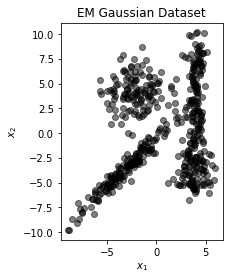

In [3]:
plot_dataset(x)
plt.show()

In [4]:
def gmm_test(covariance_type='isotropic'):
    gaussian = partial(GaussianDistribution, covariance_type=covariance_type)
    gmm = MixtureModel(4, distribution_type=gaussian)
    gmm.initialize(x)
    gmm.train(x)
    gmm.distribution.predict = lambda a: gmm.predict(a)
    plot_clusters_contours_ellipses(gmm.distribution, x)
    plt.show()
    print(f"mean negative marginal log-likelihood = {gmm.normalized_negative_marginal_log_likelihood(x):.3f}")
    print(f"mean negative complete log-likelihood = {gmm.normalized_negative_complete_log_likelihood(x):.3f}")

### Isotropic Case

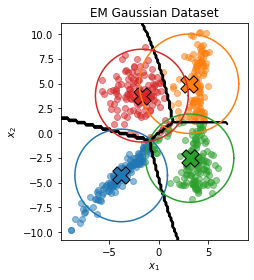

mean negative marginal log-likelihood = 5.352
mean negative complete log-likelihood = 5.638


In [5]:
gmm_test(covariance_type='isotropic')

### Full Covariance Case

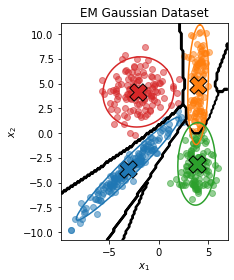

mean negative marginal log-likelihood = 4.670
mean negative complete log-likelihood = 4.748


In [6]:
gmm_test(covariance_type='full')